# Importing Libraries

In [14]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## EDA (Exploratory Data Analysis)

In [4]:
# read data

data = pd.read_csv("data/pokedex.csv")
print(data.head())
print(data.columns)
print(data.shape)

          Image  Index                    Name Type 1  Type 2  Total  HP  \
0  images/1.png      1               Bulbasaur  Grass  Poison    318  45   
1  images/2.png      2                 Ivysaur  Grass  Poison    405  60   
2  images/3.png      3                Venusaur  Grass  Poison    525  80   
3  images/4.png      3  Venusaur Mega Venusaur  Grass  Poison    625  80   
4  images/5.png      4              Charmander   Fire     NaN    309  39   

   Attack  Defense  SP. Atk.  SP. Def  Speed  
0      49       49        65       65     45  
1      62       63        80       80     60  
2      82       83       100      100     80  
3     100      123       122      120     80  
4      52       43        60       50     65  
Index(['Image', 'Index', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack',
       'Defense', 'SP. Atk.', 'SP. Def', 'Speed'],
      dtype='object')
(1215, 12)


In [5]:
# A little bit of renaming and cleaning

cleaned_data = data.rename({"Index": "ID", "Type 1": "Type"}, axis=1)
cleaned_data = cleaned_data[["Image", "ID", "Name", "Type"]]

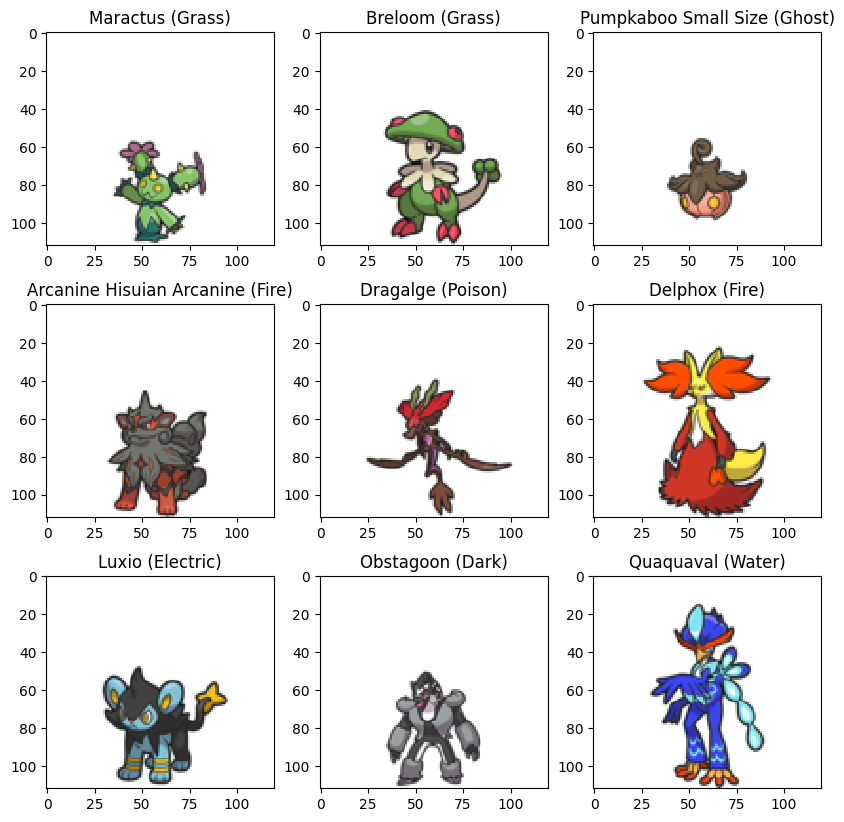

In [6]:
# Let's check on random pokemons if they look right

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        pkmn = cleaned_data.sample(1)
        # print(pkmn)
        img = Image.open(f"data/{pkmn.iloc[0]['Image']}")
        sprite = np.array(img)
        img.close()

        # print(sprite.shape)
        axes[i, j].imshow(sprite, interpolation="nearest", cmap=plt.get_cmap("gray"))
        axes[i, j].set_title(f"{pkmn.iloc[0]['Name']} ({pkmn.iloc[0]['Type']})")

plt.show()

In [7]:
# Some stats and graphs for analysis
print(cleaned_data.info())
print()
print(cleaned_data["Type"].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   1215 non-null   object
 1   ID      1215 non-null   int64 
 2   Name    1215 non-null   object
 3   Type    1215 non-null   object
dtypes: int64(1), object(3)
memory usage: 38.1+ KB
None

count      1215
unique       18
top       Water
freq        150
Name: Type, dtype: object


We can see there are 1215 data samples, all non-null, with 18 unique types

<Axes: xlabel='Type'>

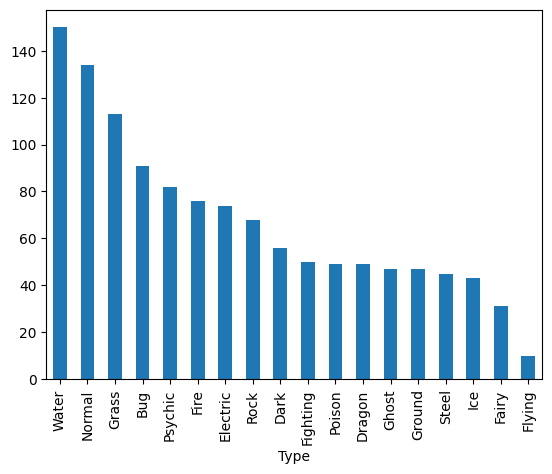

In [8]:
# cleaned_data["Type"].value_counts().plot(kind='pie')
cleaned_data["Type"].value_counts().plot(kind="bar")

The most common type is the Water Type
The least is Flying

This will cause problems with training

In [9]:
class_names = cleaned_data["Type"].unique()
print(class_names)

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Dark' 'Poison' 'Electric' 'Ground'
 'Ice' 'Fairy' 'Steel' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Dragon'
 'Flying']


## Preprocessing

In [10]:
def preprocess_image(path: str):
    """
    This function reads the image path and returns and np.ndarray containing the image data as an numpy array.
    """
    pth = f"data/{path}"
    data = None
    with Image.open(pth) as img:
        data = np.array(img)

    return data / 255


model_data = cleaned_data.copy()

# Read the image into the dataframe
model_data["Image"] = model_data["Image"].apply(preprocess_image)

# label encode Type
ll = LabelEncoder()
model_data["Type"] = ll.fit_transform(model_data["Type"])

print(model_data.sample())
print(model_data.info())

                                                 Image   ID        Name  Type
144  [[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], ...  107  Hitmonchan     5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   1215 non-null   object
 1   ID      1215 non-null   int64 
 2   Name    1215 non-null   object
 3   Type    1215 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 38.1+ KB
None


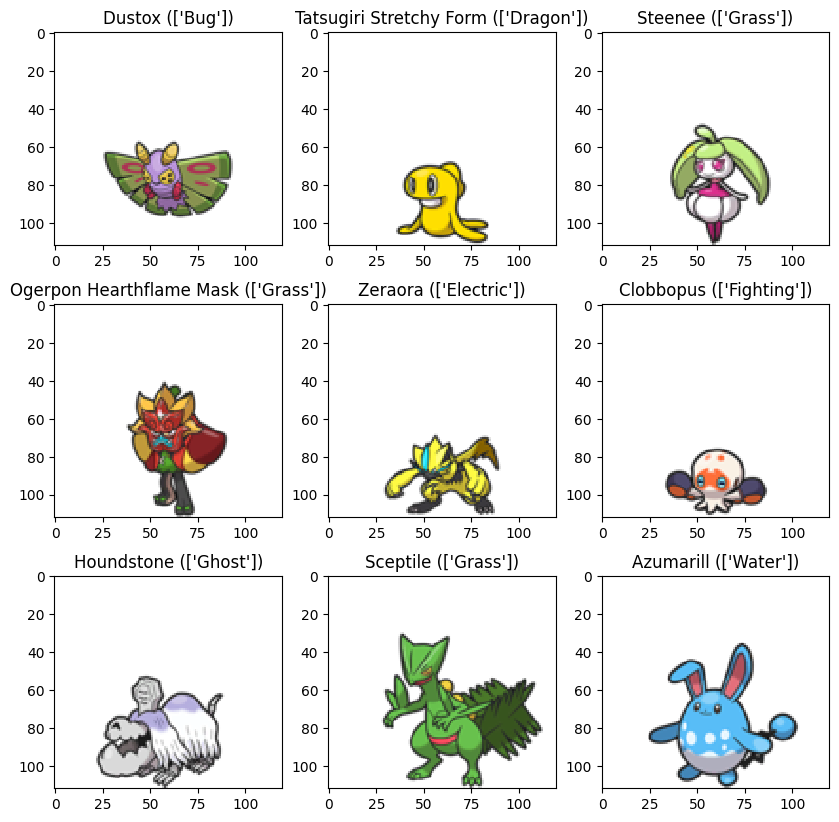

In [11]:
# Let's again check on random pokemons

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(3):
    for j in range(3):
        pkmn = model_data.sample(1)
        sprite = pkmn.iloc[0]["Image"]

        # print(sprite.shape)
        axes[i, j].imshow(
            sprite,
            interpolation="nearest",
        )
        axes[i, j].set_title(f"{pkmn.iloc[0]['Name']} ({ll.inverse_transform([pkmn.iloc[0]['Type']])})")

plt.show()

## Train, Test, Val Split

In [12]:
# print(model_data.head())
print(model_data.columns)

# train test split
X, y = np.stack(model_data["Image"].values), model_data["Type"].values
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

Index(['Image', 'ID', 'Name', 'Type'], dtype='object')
(680, 112, 120, 4) (365, 112, 120, 4) (680,) (365,) (170, 112, 120, 4) (170,)


### Enter Easy Neural Networks!

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(112, 120, 4)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(18, activation="softmax"))

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │    10,752,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 18)             │         1,818 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,774,118 (41.10 MB)

 Trainable params: 10,774,118 (41.10 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.layers

[<Flatten name=flatten_2, built=True>,
 <Dense name=dense_6, built=True>,
 <Dense name=dense_7, built=True>,
 <Dense name=dense_8, built=True>]

In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [37]:
history: keras.callbacks.History = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7989 - loss: 0.8788 - val_accuracy: 0.1059 - val_loss: 3.7112
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.7489 - loss: 0.9277 - val_accuracy: 0.1059 - val_loss: 3.5946
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8150 - loss: 0.7679 - val_accuracy: 0.0706 - val_loss: 3.4388
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8322 - loss: 0.7395 - val_accuracy: 0.1353 - val_loss: 3.3189
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9143 - loss: 0.5834 - val_accuracy: 0.1353 - val_loss: 3.5756
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8653 - loss: 0.6570 - val_accuracy: 0.1353 - val_loss: 3.7086
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8848 - loss: 0.5693 - val_accuracy: 0.1824 - val_loss: 3.3752
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9223 - loss: 0.4507 - val_accuracy: 0.1118 -

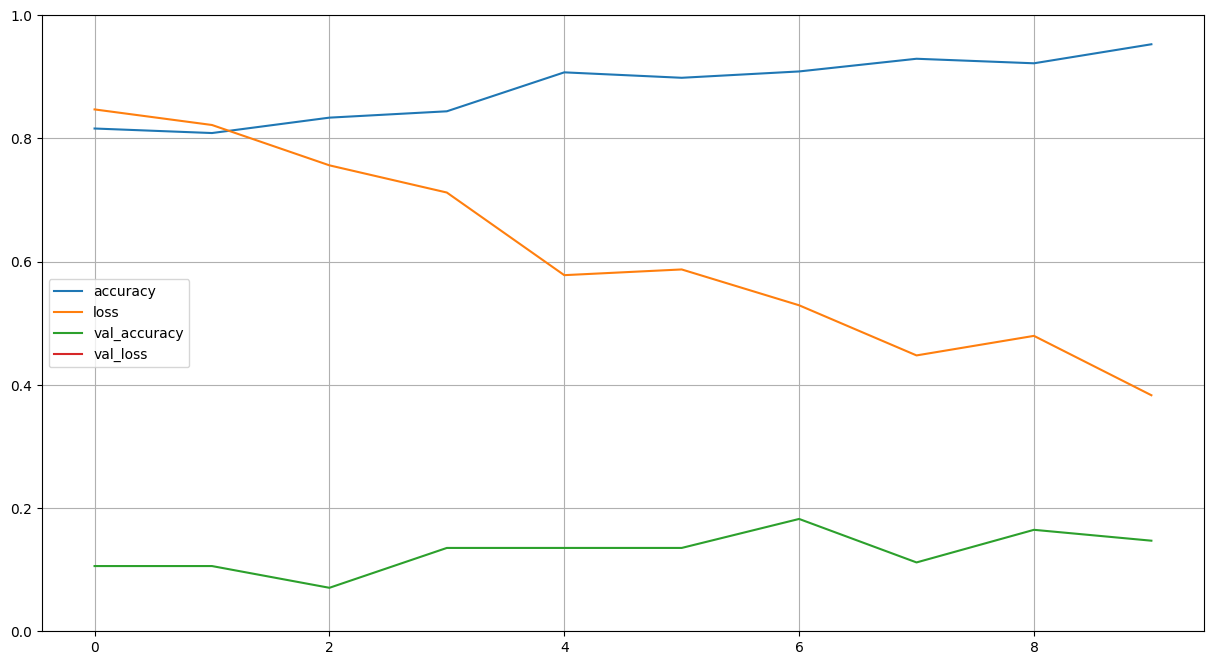

In [38]:
pd.DataFrame(history.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [39]:
model.evaluate(X_test, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1408 - loss: 3.4520


[3.3907411098480225, 0.14794521033763885]

In [40]:
y_prob: np.ndarray = model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
print(y_classes)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[ 5  6  0 14  0  1  0 10  0 12  0  6 17 16  0  6 12  2  5 10  6  9 17 16
 12 17 17  9  5  4 12 12 14 17  1  4  9 16 12 12 17 17 16 17  9  4  4  0
  0  1  0 14  0  0 14  6  0  0  0  0  0 12 17  8  6 15  5 15 17 12 17  3
 12  0 12  0  5 10  0 10  0 17 12 10  0  0  0 16  5 11  5 17  0 17 10  0
  5  2  0  0 10  9  0  9  0  0 17  3  0 17  0  1 12 17  0  0 12  5  1  0
 12  0 12 10 14 14  0  0  0 12  2  6  9 10  0  0  2  9 17  0 14 14 16  0
 14  9  0 17  0  0  3  1 14 17  5 14  0  9 15  0  5 12  6  0  0  0  0  0
  1 14  9 17  0 12 15 10  9  0  0 17 12 12  0 10  0 14 14  5  8  6  0  2
  0  0 17  0 12  0  0 17 12  0  0 17  5  5 12 17 12  2 12  0 10  5  0  0
  0  0  5 12  0 12  9 14  0 14  9  9 17 14  0  0  0  0 17  0 14  3  0 12
 12 14  1  9  4  9  0  1  0  5  9  0 17 12  6  1 17  2 14 17  5  0  0  0
 12 11  0  0  5 10  5  0  0  2  5  0  0 17 12 17 13  0 17 13  0 16 17 12
  0  0  2 17  0 12 14  0 17 16  9 14 12 17  0  0  2 12  6 17  5  0 12  0
  5 14 14  

In [42]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_classes)

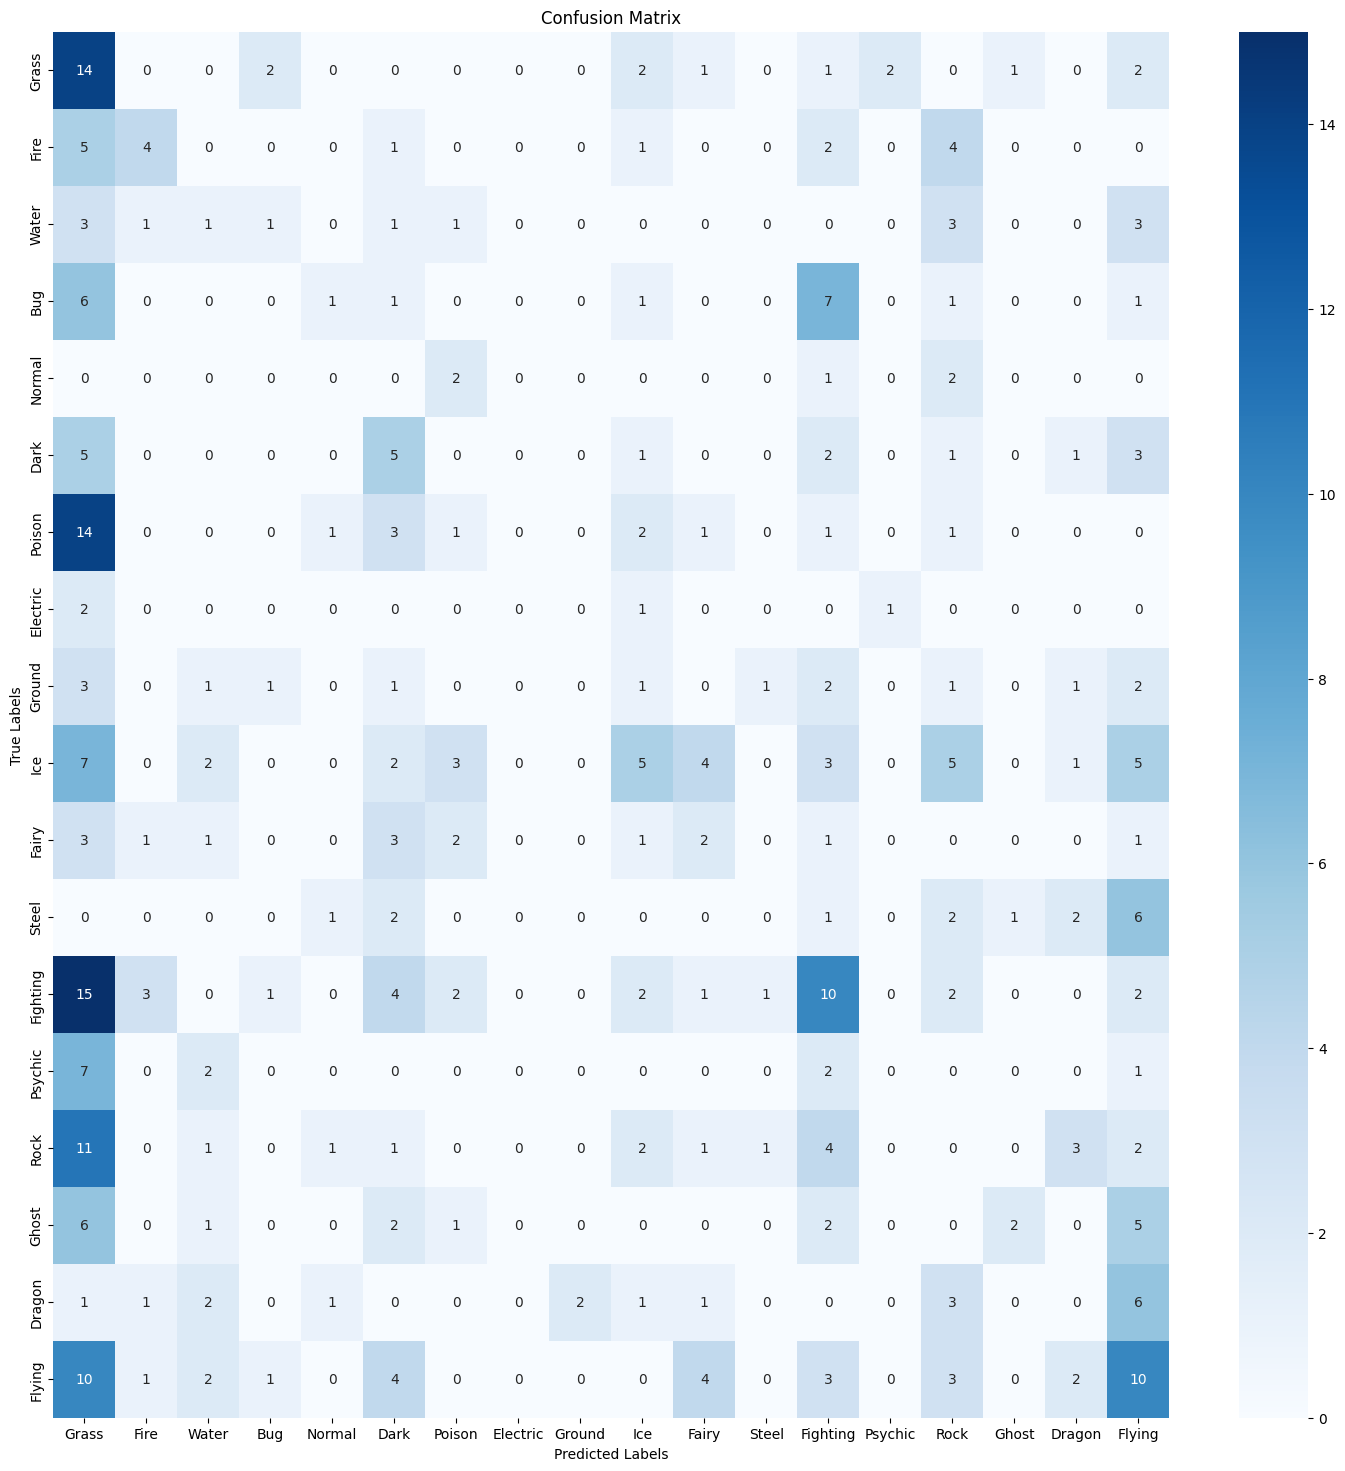

In [43]:
axs = sns.heatmap(confusion_matrix, annot=True, fmt="g", cmap="Blues")

axs.set_xlabel("Predicted Labels")
axs.set_ylabel("True Labels")
axs.set_title("Confusion Matrix")
axs.xaxis.set_ticklabels(class_names)
axs.yaxis.set_ticklabels(class_names)
axs.figure.set_size_inches(18, 18)

plt.show()

In [35]:
# Save the Model
model.save("pokemon_mnist.keras")
model.save_weights("pokemon_mnist.weights.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


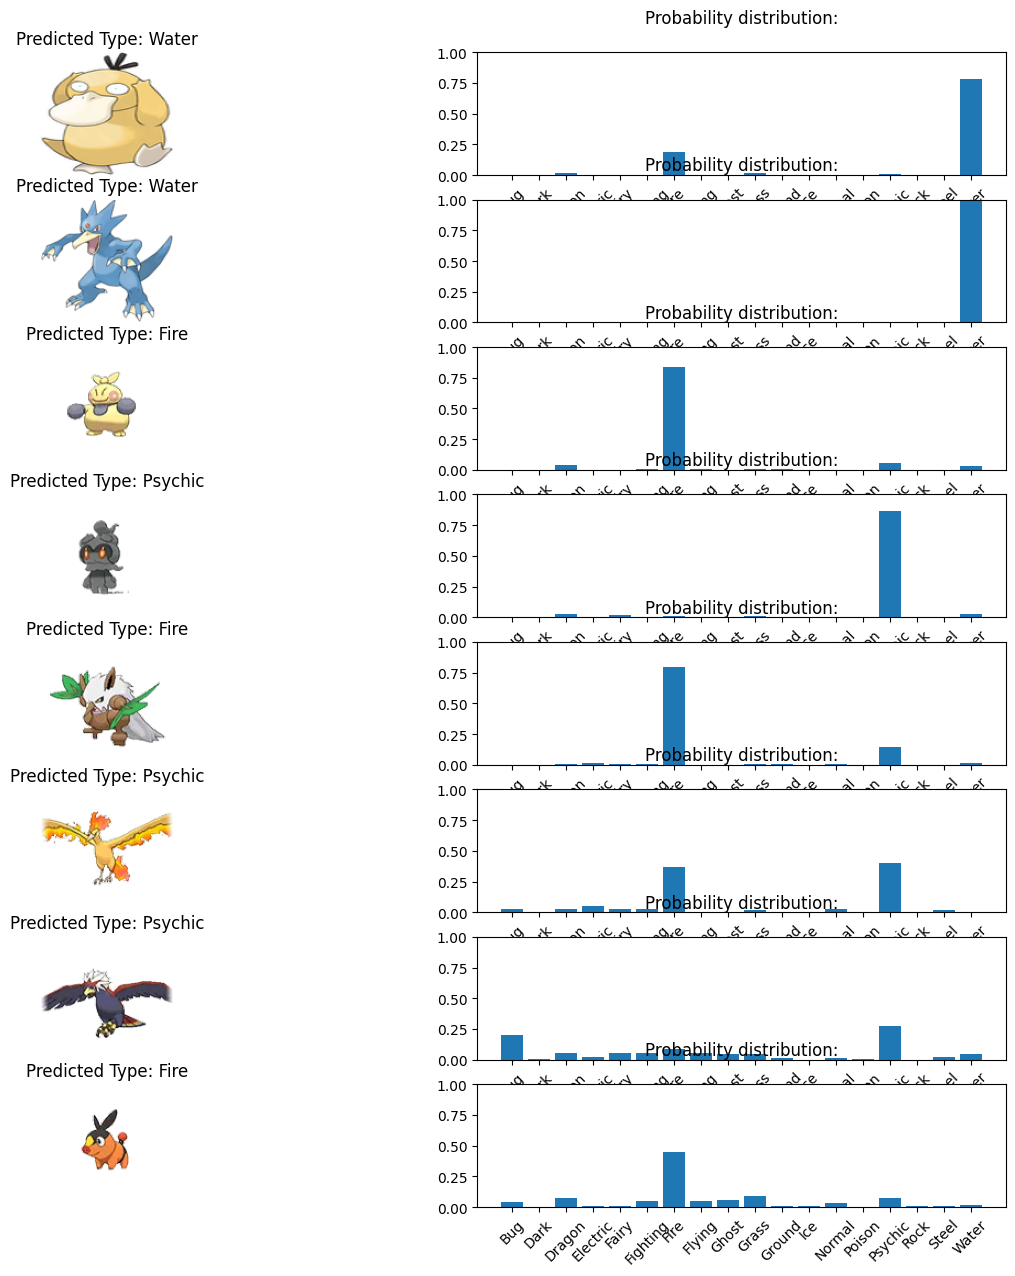

In [44]:
def preprocess_custom_image(image_path):
    img = Image.open(image_path)
    img = img.resize((120, 112))

    img = img.convert("RGBA")

    sprite = np.array(img)
    img.close()

    return sprite / 255


sprites = np.array(
    [
        preprocess_custom_image("test/psyduck.png"),
        preprocess_custom_image("test/golduck.png"),
        preprocess_custom_image("test/makuhita.png"),
        preprocess_custom_image("test/marshadow.webp"),
        preprocess_custom_image("test/shiftry.webp"),
        preprocess_custom_image("test/moltres.webp"),
        preprocess_custom_image("test/braviary.webp"),
        preprocess_custom_image("test/tepig.webp"),
    ]
)

sprites_t = tf.convert_to_tensor(sprites, dtype=tf.float32)

pred = model.predict(sprites_t)
predicted_classes = np.argmax(pred, axis=1)
predicted_types = ll.inverse_transform(predicted_classes)

# Visualize the test
fig, axes = plt.subplots(nrows=len(sprites), ncols=2, figsize=(15, 15))

for i, img in enumerate(sprites):
    # plot image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Predicted Type: {predicted_types[i]}")
    axes[i, 0].axis("off")

    # plot distribution
    axes[i, 1].set_title("Probability distribution:\n")
    prediction_prob = []
    types = []
    for type_name, prob in zip(ll.classes_, pred[i]):
        prediction_prob.append(prob)
        types.append(type_name)

    axes[i, 1].bar(types, prediction_prob)
    axes[i, 1].tick_params(axis="x", rotation=45)
    axes[i, 1].set_ylim(0, 1)

plt.show()